In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [26]:
def draw_trajectory(transforms_path, ax, color='r', size=20, interval=1, view_num=1):
    plt.style.use('seaborn-whitegrid')
    legend_flag = False
    

    with open(transforms_path) as json_file:
        contents = json.load(json_file)
        fovx = contents["camera_angle_x"]
        frames = contents["frames"]
        delta = 0.0
        cnt = 0
        pre_pos = None

        for idx, frame in enumerate(frames):
            if idx % (interval * view_num) != 0:
                continue
            file_path = os.path.split(frame['file_path'])[-1]
            # transform a to list
            c2w = np.array(frame['transform_matrix'])

            pos = c2w[:3, 3]  # camera center position
            x_dir = c2w[:3, 0]
            y_dir = c2w[:3, 1]
            z_dir = c2w[:3, 2]

            x_head_width = size * np.linalg.norm(x_dir[:2]) / 2
            z_head_width = size * np.linalg.norm(z_dir[:2]) / 2
            if z_head_width < 0.01:
                print('Here')

            ax.arrow(pos[0], pos[1], size * x_dir[0], size * x_dir[1], color='r', head_width=x_head_width, label='x-axis')
            # ax.arrow(pos[0], pos[1], size * y_dir[0], size * y_dir[1], color='g', head_width=size/2, label='y-axis')
            ax.arrow(pos[0], pos[1], size * z_dir[0], size * z_dir[1], color='b', head_width=z_head_width, label='z-axis')
            if not legend_flag:
                ax.legend()
                legend_flag = True
            
            if pre_pos is None:
                pre_pos = pos
            else:
                delta += np.linalg.norm(pos - pre_pos)
                cnt += 1.0
                pre_pos = pos

    base_step = delta / cnt / interval
    print('Average step length: {:.2f}/{:.2f}m'.format(base_step * interval, base_step))
    print('Total images: {}/{}'.format(int(cnt), len(frames)))

    ax.axis('equal')
    ax.set_xlabel('x/m')
    ax.set_ylabel('y/m')

Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Average step length: 10.12/2.02m
Total images: 139/696


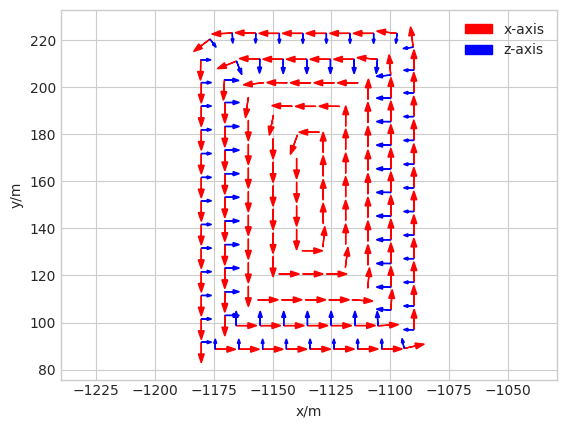

In [27]:
# data_path, subset = '../data/UE-collected', 'vehicle-train-20231114'
transforms_path = os.path.join('../data/UE-collected/aerial/block2/transforms_train.json')
fig = plt.figure()
ax = fig.gca()
draw_trajectory(transforms_path, ax, color='r', size=5, interval=5, view_num=1)
plt.show()